In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import statsmodels for mixed linear models
import statsmodels.formula.api as smf

# Load Data

In [3]:
df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_cleaned_no_outliers.csv')

# Correlation matrix

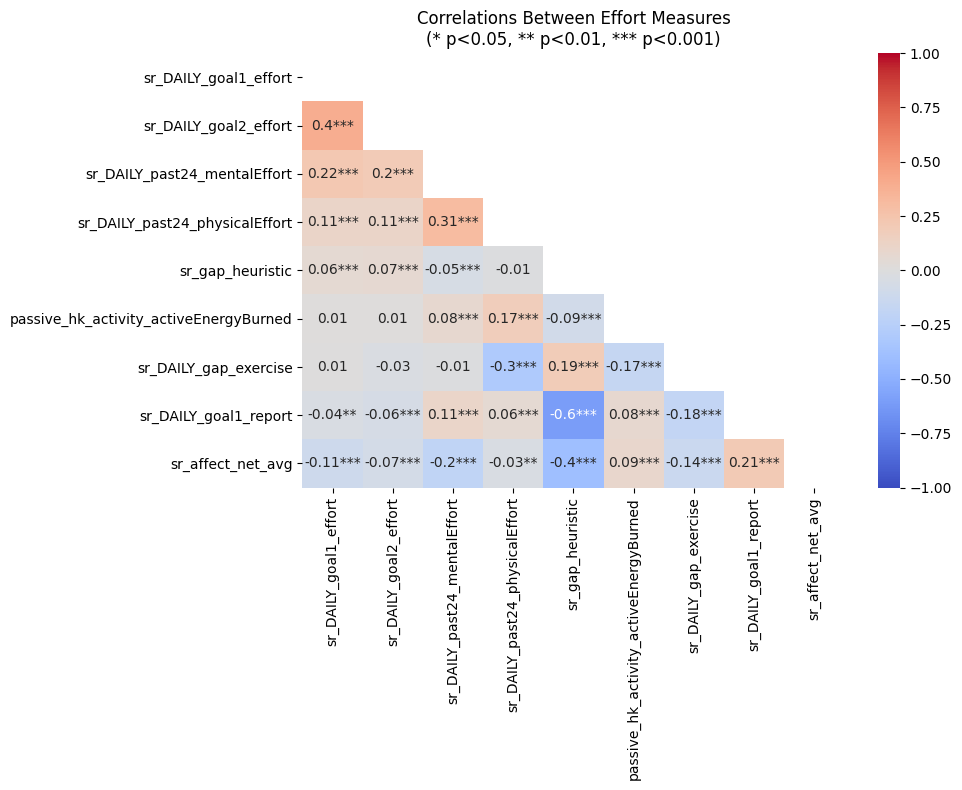

In [38]:
# Create correlation matrix for effort variables
effort_cols = ['sr_DAILY_goal1_effort',
               'sr_DAILY_goal2_effort', 
               'sr_DAILY_past24_mentalEffort',
               'sr_DAILY_past24_physicalEffort',
               'sr_gap_heuristic',
               'passive_hk_activity_activeEnergyBurned',
               'sr_DAILY_gap_exercise',
               'sr_DAILY_goal1_report',
               'sr_affect_net_avg']

# Calculate correlations and p-values using pairwise complete observations
corr_matrix = df[effort_cols].corr(method='pearson', min_periods=1)
p_matrix = pd.DataFrame(np.zeros_like(corr_matrix), 
                       columns=effort_cols, 
                       index=effort_cols)

from scipy import stats

for i in range(len(effort_cols)):
    for j in range(len(effort_cols)):
        if i != j:
            # Get pairwise complete observations for each pair
            pair_df = df[[effort_cols[i], effort_cols[j]]].dropna()
            stat, p = stats.pearsonr(pair_df[effort_cols[i]], 
                                   pair_df[effort_cols[j]])
            p_matrix.iloc[i,j] = p

# Create annotation matrix with stars for significance
annot_matrix = corr_matrix.round(2).astype(str)
for i in range(len(effort_cols)):
    for j in range(len(effort_cols)):
        if i != j:  # Skip diagonal elements
            if p_matrix.iloc[i,j] < 0.001:
                annot_matrix.iloc[i,j] += '***'
            elif p_matrix.iloc[i,j] < 0.01:
                annot_matrix.iloc[i,j] += '**'
            elif p_matrix.iloc[i,j] < 0.05:
                annot_matrix.iloc[i,j] += '*'
        else:
            annot_matrix.iloc[i,j] = ''  # Empty string for diagonal

# Create mask for upper triangle and diagonal
mask = np.triu(np.ones_like(corr_matrix), k=0)  # Changed k=1 to k=0 to include diagonal

# Create heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=annot_matrix,
            fmt='',
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0,
            mask=mask)
plt.title('Correlations Between Effort Measures\n(* p<0.05, ** p<0.01, *** p<0.001)')
plt.tight_layout()
plt.show()


<div class="alert alert-info">
<b>👆Possible takeaways?</b>:
</br> ⬆ mental effort, ⬇ physical effort.
</br> ⬆ mental effort, ⬇ physical effort.
</div>

In [36]:
def single_var_mlm(df, predictor, target, random_slopes=True, random_intercepts=True):
    """
    Fits a mixed linear model predicting one variable from another with optional random effects.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the required columns: 'PID', 'day', and the specified predictor and target
    predictor : str
        Name of the predictor variable column in df
    target : str
        Name of the target variable column in df
    random_slopes : bool, default=True
        Whether to include random slopes in the model
    random_intercepts : bool, default=True 
        Whether to include random intercepts in the model
        
    Returns
    -------
    statsmodels.regression.mixed_linear_model.MixedLMResults
        The fitted model results
    """
    # Prepare data
    model_df = df[['PID', 'day', predictor, target]].dropna().reset_index(drop=True)

    # Normalize predictor
    model_df[predictor] = (
        model_df[predictor] - model_df[predictor].mean()
    ) / model_df[predictor].std()

    # Drop any NAs created by normalization
    model_df = model_df.dropna().reset_index(drop=True)

    # Set up random effects formula based on parameters
    if random_slopes and random_intercepts:
        re_formula = f"~{predictor}"
    elif random_intercepts:
        re_formula = "~1"
    elif random_slopes:
        re_formula = f"~0 + {predictor}"
    else:
        re_formula = "~0"

    # Fit MLM with specified random effects nested within participant
    model = smf.mixedlm(
        f"{target} ~ {predictor}", 
        data=model_df,
        groups="PID",
        re_formula=re_formula
    )
    
    results = model.fit(method='nm',
                       maxiter=10000,
                       start_params=None,
                       reml=True,
                       tol=1e-8,
                       full_output=True,
                       maxfun=5000)  # Using Nelder-Mead optimizer
    
    return results


# Data Viz

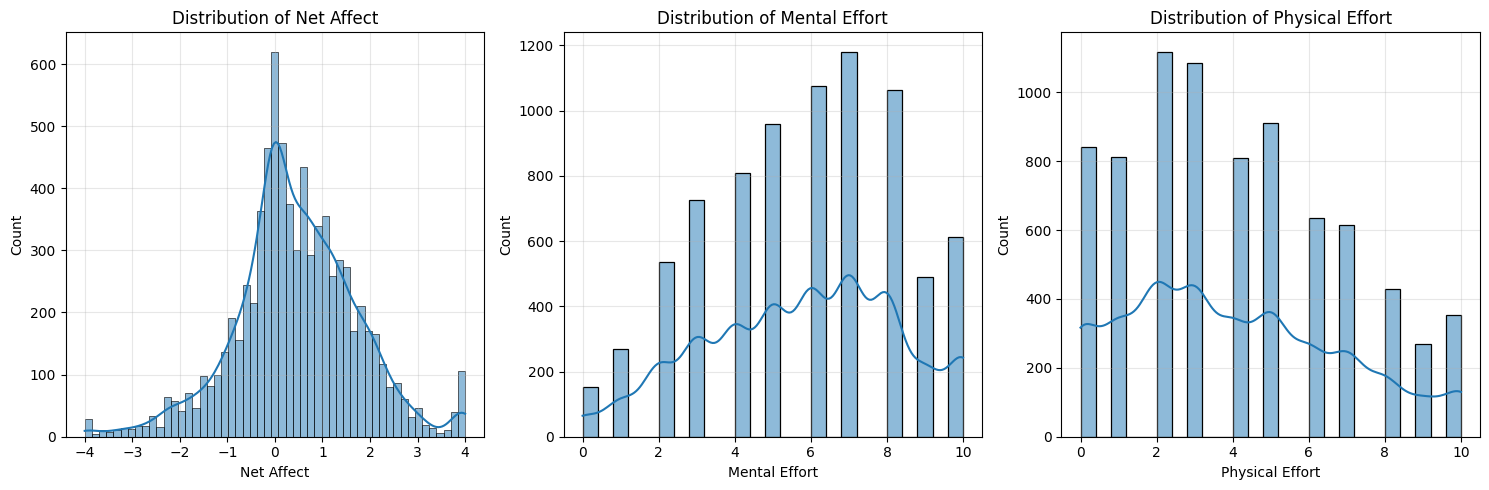

In [ ]:
# Plot distributions
import seaborn as sns

# Create a figure with 3 subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot net affect
sns.histplot(data=df['sr_affect_net_avg'], kde=True, ax=ax1)
ax1.set_xlabel('Net Affect')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Net Affect')
ax1.grid(True, alpha=0.3)

# Plot mental effort
sns.histplot(data=df['sr_DAILY_past24_mentalEffort'], kde=True, ax=ax2)
ax2.set_xlabel('Mental Effort')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Mental Effort')
ax2.grid(True, alpha=0.3)

# Plot physical effort
sns.histplot(data=df['sr_DAILY_past24_physicalEffort'], kde=True, ax=ax3)
ax3.set_xlabel('Physical Effort')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Physical Effort')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sanity checks

Does our self-report variable of physical effort (`sr_DAILY_past24_physicalEffort`) relate to:
- Gap between planned and actual exercise time (`sr_DAILY_gap_exercise`)
- Active energy burned (`passive_hk_activity_activeEnergyBurned`)

In [40]:
# Gap between planned and actual exercise time (self report)
single_var_mlm(df, 
               predictor='sr_DAILY_gap_exercise', 
               target='sr_DAILY_past24_physicalEffort').summary()

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2137: UserWarning: Argument maxfun not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:            MixedLM Dependent Variable: sr_DAILY_past24_physicalEffort
No. Observations: 1474    Method:             REML                          
No. Groups:       85      Scale:              4.3838                        
Min. group size:  1       Log-Likelihood:     -3278.6705                    
Max. group size:  77      Converged:          Yes                           
Mean group size:  17.3                                                      
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          4.656    0.192 24.226 0.000  4.279  5.032
sr_DAILY_gap_exercise             -1.065    0.122 -8.731 0.000 -1.304 -0.826
PID Var                            2.151    0.212                           
PID x sr_DAILY_gap_exercise Cov    0.254    0.091                           
sr_DAILY_gap_exercise Var          0.446    0.077                           
============================================================================

"""

<div class="alert alert-info">
<b>👆Interpretation</b>:</br> Reporting a larger exercise gap is associated with reporting less physical effort.
</div>

In [41]:
# Active energy burned (Apple Watch)

single_var_mlm(df, 
               predictor='passive_hk_activity_activeEnergyBurned', 
               target='sr_DAILY_past24_physicalEffort').summary()

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2137: UserWarning: Argument maxfun not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
===========================================================================================
Model:                 MixedLM      Dependent Variable:      sr_DAILY_past24_physicalEffort
No. Observations:      6633         Method:                  REML                          
No. Groups:            102          Scale:                   4.4831                        
Min. group size:       6            Log-Likelihood:          -14629.6678                   
Max. group size:       84           Converged:               Yes                           
Mean group size:       65.0                                                                
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         3.985    0.177 22.456 0.000  3.637  4.333
passive_hk_activity_activeEnergyBurned            0.398    0.064  6.243 0.000  0.273  0.522
PID Var                                           3.099    0.215                           
PID x passive_hk_activity_activeEnergyBurned Cov -0.236    0.055                           
passive_hk_activity_activeEnergyBurned Var        0.239    0.027                           
===========================================================================================

"""

<div class="alert alert-info">
<b>👆Interpretation</b>:</br> Lower active energy burned values captured by a wearable are associated with reporting less physical effort.
</div>

# Affect + Effort ?

In [42]:
# Physical effort + Affect

single_var_mlm(df, 
               predictor='sr_DAILY_past24_physicalEffort', 
               target='sr_affect_net_avg').summary()

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2137: UserWarning: Argument maxfun not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                  MixedLM       Dependent Variable:       sr_affect_net_avg
No. Observations:       7814          Method:                   REML             
No. Groups:             105           Scale:                    0.6821           
Min. group size:        39            Log-Likelihood:           -9901.2933       
Max. group size:        84            Converged:                Yes              
Mean group size:        74.4                                                     
---------------------------------------------------------------------------------
                                         Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                                0.451    0.097 4.668 0.000  0.261  0.640
sr_DAILY_past24_physicalEffort           0.061    0.024 2.512 0.012  0.013  0.108
PID Var                                  0.963    0.165                          
PID x sr_DAILY_past24_physicalEffort Cov 0.032    0.029                          
sr_DAILY_past24_physicalEffort Var       0.040    0.010                          
=================================================================================

"""

<div class="alert alert-info">
<b>👆Interpretation</b>:
</br> Reporting more physical effort is associated with reporting higher net affect.
</div>

In [43]:
# Mental effort + Affect

single_var_mlm(df, 
               predictor='sr_DAILY_past24_mentalEffort', 
               target='sr_affect_net_avg').summary()

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2137: UserWarning: Argument maxfun not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                  MixedLM       Dependent Variable:       sr_affect_net_avg
No. Observations:       7814          Method:                   REML             
No. Groups:             105           Scale:                    0.6540           
Min. group size:        39            Log-Likelihood:           -9760.2817       
Max. group size:        84            Converged:                Yes              
Mean group size:        74.4                                                     
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.465    0.091  5.113 0.000  0.287  0.643
sr_DAILY_past24_mentalEffort           -0.162    0.029 -5.659 0.000 -0.218 -0.106
PID Var                                 0.852    0.150                           
PID x sr_DAILY_past24_mentalEffort Cov  0.022    0.033                           
sr_DAILY_past24_mentalEffort Var        0.069    0.015                           
=================================================================================

"""

<div class="alert alert-info">
<b>👆Interpretation</b>:
</br> Reporting more mental effort is associated with reporting lower net affect.
</div>

# Moderators?

😢 If you put in more mental effort than usual and fail to achieve your goal, then perhaps ⬇⬇ affect.

😃 But, if you put in more mental effort than usual and succeed, the perhaps ⬆⬆ affect.

**So perhaps the main effect is driven by the fact that we usually fail to meet our goals?**

In [49]:
# Test moderation of mental effort -> affect relationship by goal achievement
import statsmodels.formula.api as smf
from scipy import stats

# Create dataframe with only relevant columns and normalize predictors
model_df = df[['PID', 'sr_affect_net_avg', 'sr_DAILY_past24_mentalEffort', 'sr_gap_heuristic']].copy()

# Drop NaN values first
model_df = model_df.dropna().reset_index(drop=True)

# Calculate z-scores within each PID group
model_df['sr_DAILY_past24_mentalEffort'] = model_df.groupby('PID')['sr_DAILY_past24_mentalEffort'].transform(lambda x: stats.zscore(x))
model_df['sr_gap_heuristic'] = model_df.groupby('PID')['sr_gap_heuristic'].transform(lambda x: stats.zscore(x))
model_df = model_df.dropna().reset_index(drop=True)

model = smf.mixedlm(
    "sr_affect_net_avg ~ sr_DAILY_past24_mentalEffort * sr_gap_heuristic", 
    data=model_df,
    groups="PID"
)

model.fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                      MixedLM         Dependent Variable:         sr_affect_net_avg
No. Observations:           7814            Method:                     REML             
No. Groups:                 105             Scale:                      0.6508           
Min. group size:            39              Log-Likelihood:             -9666.0539       
Max. group size:            84              Converged:                  Yes              
Mean group size:            74.4                                                         
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      0.434    0.095   4.551 0.000  0.247  0.621
sr_DAILY_past24_mentalEffort                  -0.141    0.009 -15.431 0.000 -0.159 -0.123
sr_gap_heuristic                              -0.200    0.009 -21.813 0.000 -0.218 -0.182
sr_DAILY_past24_mentalEffort:sr_gap_heuristic -0.029    0.009  -3.443 0.001 -0.046 -0.013
PID Var                                        0.946    0.165                            
=========================================================================================

"""

So we do find a significant interaction...

### Key Points
1. #### High Mental Effort:
- On its own, high `sr_DAILY_past24_mentalEffort` negatively impacts affect with a coefficient of **-0.141**. This means affect decreases as mental effort increases.
2. #### Low Gap Heuristic:
- When `sr_gap_heuristic` is low, its standalone negative effect **(-0.200)** diminishes since low values reduce the overall influence of this variable.
3. #### Interaction Effect:
- The interaction coefficient is **-0.029**, meaning the combined negative impact of mental effort and gap heuristic grows stronger as both values increase. When gap heuristic is low, the interaction term becomes negligible because the product of the two variables (**MentalEffort × GapHeuristic**) is small.
- Thus, the effect of mental effort remains closer to its main effect (**-0.141**) without a significant amplifying influence from the interaction.

### Practical Interpretation:
When **gap heuristic** is **low**, high **mental effort** still reduces affect, but the effect is more manageable. This suggests that a **low gap heuristic** might buffer or mitigate the negative impact of mental effort on emotional well-being.

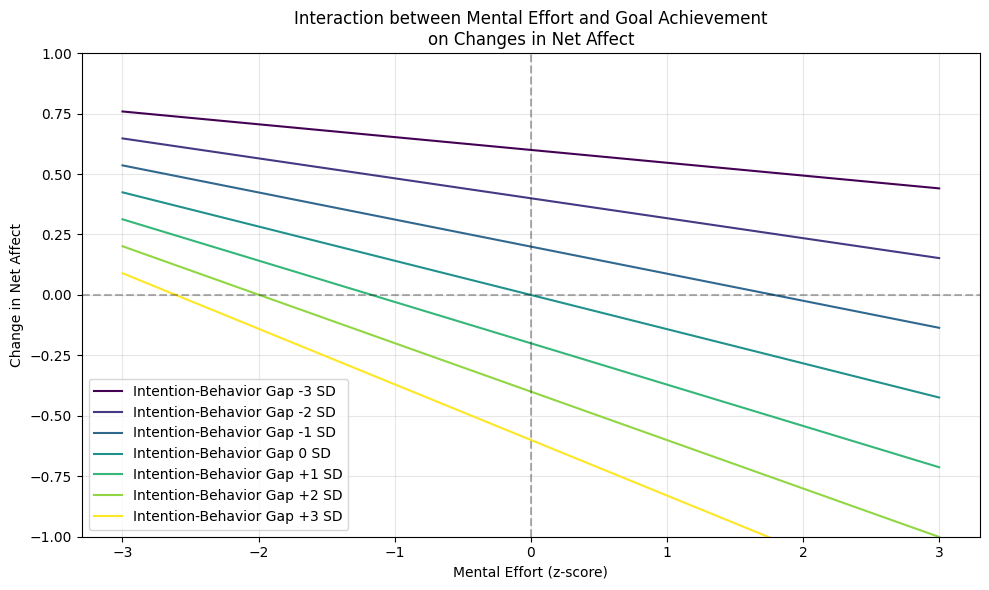

In [63]:
# Plot interaction

# Fit the model again to get coefficients
fit = model.fit()

# Create data for plotting
import numpy as np
import matplotlib.pyplot as plt

# Create range of mental effort values
mental_effort = np.linspace(-3, 3, 100)

# Calculate predicted values for different levels of gap_heuristic
gap_levels = {
    '-3 SD': -3,
    '-2 SD': -2,
    '-1 SD': -1,
    '0 SD': 0,
    '+1 SD': 1,
    '+2 SD': 2,
    '+3 SD': 3
}
predictions = {}

for gap_name, gap_value in gap_levels.items():
    predictions[gap_name] = (
        fit.params['sr_DAILY_past24_mentalEffort'] * mental_effort +
        fit.params['sr_gap_heuristic'] * gap_value +
        fit.params['sr_DAILY_past24_mentalEffort:sr_gap_heuristic'] * mental_effort * gap_value
    )

# Create the plot
plt.figure(figsize=(10, 6))

# Plot lines for each gap_heuristic level using viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(gap_levels)))
for (gap_name, pred), color in zip(predictions.items(), colors):
    plt.plot(mental_effort, pred, label=f'Intention-Behavior Gap {gap_name}', color=color)

plt.xlabel('Mental Effort (z-score)')
plt.ylabel('Change in Net Affect')
plt.title('Interaction between Mental Effort and Goal Achievement\non Changes in Net Affect')
plt.legend()
plt.grid(True, alpha=0.3)

# Add vertical line at x=0 and horizontal line at y=0
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Set y-axis limits
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()


We also have two daily individual goal reports that contain many additional dimensions which could potentially provide more insight into relationships between goals, accomplishment, effort, and affect.

For example👇

In [65]:
[col for col in df.columns if 'goal1' in col and 'interaction' not in col]

['sr_DAILY_goal1_confidence',
 'sr_DAILY_goal1_consequences',
 'sr_DAILY_goal1_effort',
 'sr_DAILY_goal1_importance',
 'sr_DAILY_goal1_motivationExternal',
 'sr_DAILY_goal1_motivationInternal',
 'sr_DAILY_goal1_report']